In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def formatting_image(img, a, b, blur):
    
    '''
    Formatta l'immagine agli standard del sistema di trigger_1
    '''
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # from BGR to GRAY scale
    img = cv2.convertScaleAbs(img, alpha = a, beta = b) # contrast and brightness, alpha (1-3), beta (0-100)
    img = cv2.GaussianBlur(img, ksize=(65, 65), sigmaX=blur) # blurring
    
    return img

def return_trace(frame1, frame2):
    
    a = 1
    b = 0
    blur = 10
    
    #frame1 = formatting_image(frame1, a, b, blur)
    #frame2 = formatting_image(frame2, a, b, blur)
    
    # Compute the absolute difference between the current frame and the previous frame
    frame_diff = cv2.absdiff(frame2, frame1)
    
    # Normalize the difference for better visualization
    diff = cv2.normalize(frame_diff, None, 0, 255, cv2.NORM_MINMAX)

    a = 1
    b = -70
    blur = 6

    diff = cv2.convertScaleAbs(diff, alpha = a, beta = b) # contrast and brightness, alpha (1-3), beta (0-100)
    diff = cv2.GaussianBlur(diff, ksize=(65, 65), sigmaX=blur) # blurring
   # diff = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)[1]

    #diff = 255 - diff
    
    '''
    white = 0
    gray = 100
    #mask = cv2.inRange(diff, white, gray)
    countours, _ = cv2.findContours(diff, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for contour in countours:
        area = cv2.contourArea(contour)
        if area > 300 and area < 1000:
            centroids = cv2.moments(contour)
            center_x = int(centroids['m10'] / centroids['m00'])
            center_y = int(centroids['m01'] / centroids['m00'])
            cv2.circle(diff, (center_x, center_y), 4, (0, 255, 0), -1)
            # cv2.putText(frame, '', (center_x + 10, center_y + 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    #diff = cv2.bitwise_and(diff, diff, mask=mask)
    '''
    
    return diff

1920 1080


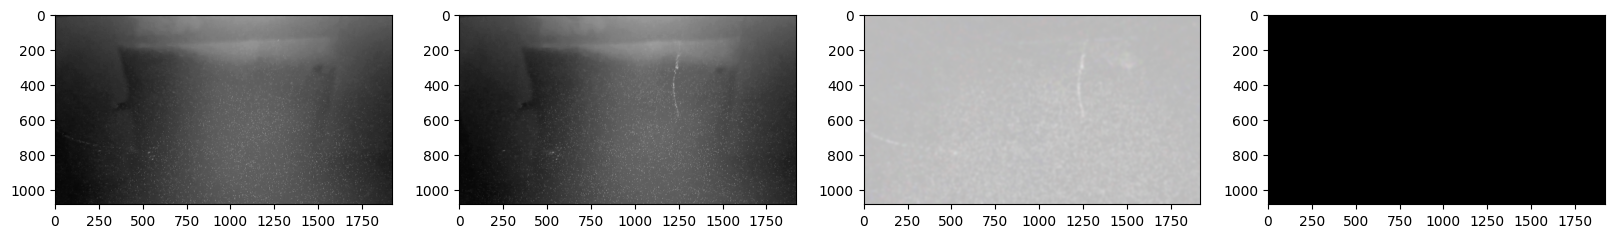

In [73]:
cap = cv2.VideoCapture(r'C:\Users\Black\Downloads\20240904_165241_1.mp4')
width = int(cap.get(3))
height = int(cap.get(4))
print(width, height)

n_frame = 245
delta_frame = 20

cap.set(cv2.CAP_PROP_POS_FRAMES, n_frame - delta_frame) # 227
ret, frame1 = cap.read()
cap.set(cv2.CAP_PROP_POS_FRAMES, n_frame) # 235
ret, frame2 = cap.read()
cap.release()

diff = return_trace(frame1, frame2)
diff = 255 - diff

fig, ax = plt.subplots(1, 4, figsize = (20, 20))
ax[0].imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY), cmap='gray')
ax[1].imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY), cmap='gray')
ax[2].imshow(diff, cmap='gray')

# Applica il filtro Sobel
sobel_x = cv2.Sobel(diff, cv2.CV_64F, 1, 0, ksize=5)  # Derivata in x
sobel_y = cv2.Sobel(diff, cv2.CV_64F, 0, 1, ksize=5)  # Derivata in y
sobel_combined = cv2.magnitude(sobel_x, sobel_y)  # Magnitudo

# Normalizza per la visualizzazione
sobel_combined = cv2.normalize(sobel_combined, None, 0, 255, cv2.NORM_MINMAX)
sobel_combined = np.uint8(sobel_combined)  # Converti a uint8

edges = cv2.Canny(sobel_combined, 20, 150)
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contour_image = np.zeros_like(diff)
cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 1)

ax[3].imshow(countour_image, cmap='gray')

In [60]:
contours

()

In [20]:
import time

def RecordVideo(cap, outfilename, record_duration_s = 3):
    # set resolution and framerate
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = 30 # getting it from cap.get(cv2.CAP_PROP_FPS) does not work for my webcam

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'H264')
    out = cv2.VideoWriter(outfilename, fourcc, fps, (frame_width, frame_height))

    print(f'Recording video for {record_duration_s} seconds with resolution {frame_width}x{frame_height}')
    time_begin = time.time()
    for i in range(0, fps * record_duration_s):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame1 = cap.read()
        cap.set(cv2.CAP_PROP_POS_FRAMES, i + delta_frame) 
        ret, frame2 = cap.read()
        img = return_trace(frame1, frame2)
        out.write(img)
    time_end = time.time()
    print(f'Elapsed time is {time_end-time_begin}')

    cap.release()
    out.release()
    print(f'Video written to {outfilename}')

# Open the video capture from the mp4 video file
cap = cv2.VideoCapture(r'C:\Users\Black\Downloads\20240904_165241_1.mp4')

# Get the number of frames in the video
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f'The video contains {n_frames} frames')

RecordVideo(cap, 'output2.mp4', record_duration_s = 3)

cap.release()

The video contains 9098 frames
Recording video for 3 seconds with resolution 1920x1080
Elapsed time is 57.38926935195923
Video written to output2.mp4
